Polygon points: [(507, 199), (681, 209)]
Polygon points: [(507, 199), (681, 209), (751, 555)]
Polygon points: [(507, 199), (681, 209), (751, 555), (484, 541)]
Saved polygon coordinates: [[507 199]
 [681 209]
 [751 555]
 [484 541]]


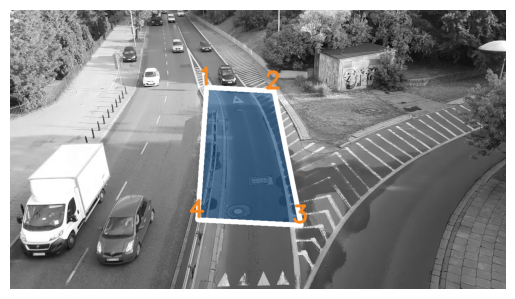

In [2]:
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

clicked_points = []

def mouse_callback(event, x, y, flags, param):
    global clicked_points, img_copy
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        
        cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1) 
        cv2.putText(img_copy, f"({x},{y})", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-2], clicked_points[-1], (0, 255, 0), 2)  

        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-1], clicked_points[0], (0, 255, 0), 2) 
            print("Polygon points:", clicked_points)
            
            color1 = sv.Color.from_hex("#004080")
            color2 = sv.Color.from_hex("#f78923")
            img_copy = sv.draw_filled_polygon(img_copy, np.array(clicked_points), color1, 0.5)
            img_copy = sv.draw_polygon(img_copy, np.array(clicked_points), sv.Color.WHITE, 12)
            
            for i, point in enumerate(clicked_points):
                img_copy = sv.draw_text(
                    img_copy, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
                )

video_path = './asset/videoplayback.mp4'  
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", mouse_callback)

while True:
    ret, frame = cap.read()
    
    if not ret:
        break  
    
    img = frame.copy()

    img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

    img_copy = img.copy()
    
    cv2.imshow("Frame", img_copy)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  
        break

cap.release()
cv2.destroyAllWindows()

POLYGON_COORDS = np.array(clicked_points)

print("Saved polygon coordinates:", POLYGON_COORDS)

cap = cv2.VideoCapture(video_path)
ret, img = cap.read()
cap.release()

img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")

img = sv.draw_filled_polygon(img, POLYGON_COORDS, color1, 0.5)
img = sv.draw_polygon(img, POLYGON_COORDS, sv.Color.WHITE, 12)

for i, point in enumerate(POLYGON_COORDS):
    img = sv.draw_text(
        img, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
    )

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

In [ ]:
import cv2
import numpy as np
import time
from collections import defaultdict, Counter, deque
from ultralytics import YOLO
import supervision as sv
import csv
import os

# ---------- CONFIGURATION ---------- #

VIDEO_PATH = './asset/videoplayback.mp4'
OUTPUT_VIDEO_PATH = './asset/TrackingWithStopResult.mp4'
OUTPUT_CSV_PATH = './asset/tracking_results.csv'
COUNT_CSV_PATH = './asset/vehicle_count.csv'
MODEL_PATH = 'yolo11n.pt'

SOURCE_POLYGON = np.array([
    (422, 10),   # Top-left
    (594, 16),   # Top-right
    (801, 665),  # Bottom-right
    (535, 649)   # Bottom-left
])

STOP_ZONE_POLYGON = np.array([(507, 199), (681, 209), (751, 555), (484, 541)])
TARGET_WIDTH, TARGET_HEIGHT = 50, 130
VELOCITY_THRESHOLD = 0.5  # Adjusted for normalized space (tune this value)
FRAME_BUFFER = 20
CSV_UPDATE_INTERVAL = 5

CLASS_NAMES = {
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck"
}

# ---------- CLASSES ---------- #

class ViewTransformer:
    def __init__(self, source: np.ndarray, target_size: tuple[int, int]):
        target = np.array([
            [0, 0],
            [target_size[0] - 1, 0],
            [target_size[0] - 1, target_size[1] - 1],
            [0, target_size[1] - 1]
        ], dtype=np.float32)
        self.m = cv2.getPerspectiveTransform(source.astype(np.float32), target)

    def transform(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), self.m).reshape(-1, 2)

# ---------- HELPERS ---------- #

def point_inside_polygon(point, polygon):
    return cv2.pointPolygonTest(polygon.astype(np.float32), tuple(map(float, point)), False) >= 0

def initialize_csv(filepath, fieldnames):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    csvfile = open(filepath, mode='w', newline='')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    return csvfile, writer

# ---------- MAIN PIPELINE ---------- #

def main():
    video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
    video_info.fps = 30

    model = YOLO(MODEL_PATH)
    model.fuse()
    tracker = sv.ByteTrack(frame_rate=video_info.fps)
    frame_gen = sv.get_video_frames_generator(source_path=VIDEO_PATH)

    thickness = 1
    text_scale = 0.4
    annotators = {
        'box': sv.BoxAnnotator(thickness=thickness),
        'trace': sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps * 2, position=sv.Position.BOTTOM_CENTER),
        'label_top': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.TOP_LEFT),
        'label_bottom': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.BOTTOM_CENTER)
    }

    polygon_zone = sv.PolygonZone(polygon=SOURCE_POLYGON)
    stop_zone = sv.PolygonZone(polygon=STOP_ZONE_POLYGON)
    transformer = ViewTransformer(SOURCE_POLYGON, (TARGET_WIDTH, TARGET_HEIGHT))

    tracker_types = {}
    position_history = defaultdict(lambda: deque(maxlen=FRAME_BUFFER))  # Stores transformed points
    status_cache = {}
    compliance_set = set()
    stop_zone_history = {}
    counted_ids = set()
    vehicle_type_counter = Counter()
    entry_times = {}
    reaction_times = {}
    csv_updates = {}

    csvfile, writer = initialize_csv(OUTPUT_CSV_PATH, ["tracker_id", "vehicle_type", "status", "compliance", "reaction_time"])
    count_csvfile, count_writer = initialize_csv(COUNT_CSV_PATH, ["vehicle_type", "count"])

    frame_idx = 0
    start_time = time.time()
    prev_fps_time = start_time

    try:
        with sv.VideoSink(OUTPUT_VIDEO_PATH, video_info) as sink:
            for frame in frame_gen:
                frame_idx += 1
                result = model(frame, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > 0.3]
                detections = detections[polygon_zone.trigger(detections)].with_nms(threshold=0.6)
                detections = tracker.update_with_detections(detections)

                anchor_pts = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                transformed_pts = transformer.transform(anchor_pts).astype(float)  # Use transformed points

                top_labels, bottom_labels = [], []

                for track_id, orig_pt, trans_pt, class_id in zip(
                    detections.tracker_id, anchor_pts, transformed_pts, detections.class_id
                ):
                    vehicle_type = tracker_types.setdefault(track_id, CLASS_NAMES.get(class_id, "unknown"))
                    status = "moving"
                    compliance = 0

                    # Store transformed points for velocity calculation
                    position_history[track_id].append(trans_pt)

                    if point_inside_polygon(orig_pt, STOP_ZONE_POLYGON):
                        if track_id not in counted_ids:
                            vehicle_type_counter[vehicle_type] += 1
                            counted_ids.add(track_id)

                        if track_id not in entry_times:
                            entry_times[track_id] = time.time()
                            stop_zone_history[track_id] = {
                                "vehicle_type": vehicle_type,
                                "status": "entered",
                                "compliance": 0,
                                "reaction_time": None
                            }
                            csv_updates[track_id] = 1

                        if len(position_history[track_id]) >= FRAME_BUFFER:
                            displacements = np.array([
                                np.linalg.norm(position_history[track_id][i] - position_history[track_id][i - 1])
                                for i in range(1, len(position_history[track_id]))
                            ])
                            weights = np.linspace(1, 2, len(displacements))
                            avg_velocity = np.average(displacements, weights=weights)

                            if avg_velocity < VELOCITY_THRESHOLD:
                                status, compliance = "stationary", 1
                                compliance_set.add(track_id)

                                if track_id not in reaction_times:
                                    reaction_times[track_id] = round(time.time() - entry_times[track_id], 2)
                                    if csv_updates.get(track_id, 0) < 2:
                                        stop_zone_history[track_id] = {
                                            "vehicle_type": vehicle_type,
                                            "status": status,
                                            "compliance": compliance,
                                            "reaction_time": reaction_times[track_id]
                                        }
                                        csv_updates[track_id] = 2
                    else:
                        position_history[track_id].clear()
                        if track_id in entry_times and track_id not in reaction_times:
                            reaction_times[track_id] = None

                    status_cache[track_id] = status
                    top_labels.append(f"{vehicle_type} {status}" if status != "moving" else vehicle_type)
                    bottom_labels.append(f"#{track_id}")

                if frame_idx % CSV_UPDATE_INTERVAL == 0:
                    csvfile.seek(0)
                    csvfile.truncate()
                    writer.writeheader()
                    for tid, data in stop_zone_history.items():
                        writer.writerow({
                            "tracker_id": tid,
                            **data
                        })
                    csvfile.flush()

                    count_csvfile.seek(0)
                    count_csvfile.truncate()
                    count_writer.writeheader()
                    for v_type, count in vehicle_type_counter.items():
                        count_writer.writerow({"vehicle_type": v_type, "count": count})
                    count_csvfile.flush()

                top_labels += [""] * (len(detections) - len(top_labels))
                bottom_labels += [""] * (len(detections) - len(bottom_labels))

                annotated = annotators['trace'].annotate(scene=frame.copy(), detections=detections)
                annotated = annotators['box'].annotate(annotated, detections)
                annotated = annotators['label_top'].annotate(annotated, detections, top_labels)
                annotated = annotators['label_bottom'].annotate(annotated, detections, bottom_labels)

                cv2.polylines(annotated, [STOP_ZONE_POLYGON], True, (0, 255, 255), 2)
                sink.write_frame(annotated)
                cv2.imshow("Tracking with Stop", annotated)

                if frame_idx % 30 == 0:
                    now = time.time()
                    fps = 30 / (now - prev_fps_time)
                    prev_fps_time = now
                    print(f"[INFO] FPS: {fps:.2f}")

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"[ERROR] {e}")
    finally:
        end_time = time.time()
        total_time = end_time - start_time
        avg_fps = frame_idx / total_time
        print(f"[INFO] Total Time: {total_time:.2f}s, Frames: {frame_idx}, Avg FPS: {avg_fps:.2f}")
        csvfile.close()
        count_csvfile.close()
        cv2.destroyAllWindows()
        print("[INFO] Tracking and counting completed successfully.")
#//
if __name__ == "__main__":
    main()

In [ ]:
import cv2
import numpy as np
import time
from collections import defaultdict, Counter, deque
from ultralytics import YOLO
import supervision as sv
import csv
import os

# ---------- CONFIGURATION ---------- #

VIDEO_PATH = './asset/videoplayback.mp4'
OUTPUT_VIDEO_PATH = './asset/TrackingWithStopResult.mp4'
OUTPUT_CSV_PATH = './asset/tracking_results.csv'
COUNT_CSV_PATH = './asset/vehicle_count.csv'
MODEL_PATH = 'yolo11n.pt'

SOURCE_POLYGON = np.array([
    (422, 10),   # Top-left
    (594, 16),   # Top-right
    (801, 665),  # Bottom-right
    (535, 649)   # Bottom-left
])

STOP_ZONE_POLYGON = np.array([(507, 199), (681, 209), (751, 555), (484, 541)])
TARGET_WIDTH, TARGET_HEIGHT = 50, 130
VELOCITY_THRESHOLD = 0.5  # Adjusted for normalized space (tune this value)
FRAME_BUFFER = 20
CSV_UPDATE_INTERVAL = 5

CLASS_NAMES = {
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck"
}

# ---------- CLASSES ---------- #

class ViewTransformer:
    def __init__(self, source: np.ndarray, target_size: tuple[int, int]):
        target = np.array([
            [0, 0],
            [target_size[0] - 1, 0],
            [target_size[0] - 1, target_size[1] - 1],
            [0, target_size[1] - 1]
        ], dtype=np.float32)
        self.m = cv2.getPerspectiveTransform(source.astype(np.float32), target)

    def transform(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), self.m).reshape(-1, 2)

# ---------- HELPERS ---------- #

def point_inside_polygon(point, polygon):
    return cv2.pointPolygonTest(polygon.astype(np.float32), tuple(map(float, point)), False) >= 0

def initialize_csv(filepath, fieldnames, mode='a'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    csvfile = open(filepath, mode=mode, newline='')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if mode == 'w':
        writer.writeheader()
    return csvfile, writer

def read_csv_to_dict(filepath):
    data = {}
    if os.path.exists(filepath):
        with open(filepath, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                tracker_id = row['tracker_id']
                data[tracker_id] = row
    return data

def update_csv_files(output_path, count_path, history_dict, vehicle_counter):
    """Update CSV files with current tracking data"""
    try:
        with open(output_path, 'w', newline='') as csv_update_file:
            update_writer = csv.DictWriter(csv_update_file, 
                fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time"])
            update_writer.writeheader()
            for tid, data in history_dict.items():
                update_writer.writerow(data)

        with open(count_path, 'w', newline='') as count_update_file:
            count_update_writer = csv.DictWriter(count_update_file, fieldnames=["vehicle_type", "count"])
            count_update_writer.writeheader()
            for v_type, count in vehicle_counter.items():
                count_update_writer.writerow({"vehicle_type": v_type, "count": count})
                
        return True
    except Exception as e:
        print(f"[WARNING] Failed to update CSV files: {e}")
        return False

# ---------- MAIN ---------- #

def main():
    video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
    video_info.fps = 30

    model = YOLO(MODEL_PATH)
    model.fuse()
    tracker = sv.ByteTrack(frame_rate=video_info.fps)
    frame_gen = sv.get_video_frames_generator(source_path=VIDEO_PATH)

    thickness = 1
    text_scale = 0.4
    annotators = {
        'box': sv.BoxAnnotator(thickness=thickness),
        'trace': sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps * 2, position=sv.Position.BOTTOM_CENTER),
        'label_top': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.TOP_LEFT),
        'label_bottom': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.BOTTOM_CENTER)
    }

    polygon_zone = sv.PolygonZone(polygon=SOURCE_POLYGON)
    stop_zone = sv.PolygonZone(polygon=STOP_ZONE_POLYGON)
    transformer = ViewTransformer(SOURCE_POLYGON, (TARGET_WIDTH, TARGET_HEIGHT))

    tracker_types = {}
    position_history = defaultdict(lambda: deque(maxlen=FRAME_BUFFER))
    status_cache = {}
    compliance_set = set()
    stop_zone_history = {}
    counted_ids = set()
    vehicle_type_counter = Counter()
    entry_times = {}
    reaction_times = {}
    
    # Track which vehicle records have been written to CSV
    written_records = set()  # Set of (tracker_id, status) tuples
    
    stop_zone_history_dict = read_csv_to_dict(OUTPUT_CSV_PATH)
    
    # We'll handle file operations directly when needed
    if not os.path.exists(OUTPUT_CSV_PATH) or os.path.getsize(OUTPUT_CSV_PATH) == 0:
        with open(OUTPUT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time"])
            writer.writeheader()
            
    if not os.path.exists(COUNT_CSV_PATH) or os.path.getsize(COUNT_CSV_PATH) == 0:
        with open(COUNT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["vehicle_type", "count"])
            writer.writeheader()

    max_track_id = 0
    for tid in stop_zone_history_dict.keys():
        try:
            tid_int = int(tid)
            max_track_id = max(max_track_id, tid_int)
        except ValueError:
            continue

    tracker_id_offset = max_track_id
    if max_track_id > 0:
        print(f"[INFO] Continuing from tracker ID: {tracker_id_offset + 1}")

    frame_idx = 0
    start_time = time.time()
    prev_fps_time = start_time

    try:
        with sv.VideoSink(OUTPUT_VIDEO_PATH, video_info) as sink:
            for frame in frame_gen:
                frame_idx += 1
                result = model(frame, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > 0.3]
                detections = detections[polygon_zone.trigger(detections)].with_nms(threshold=0.6)
                detections = tracker.update_with_detections(detections)

                # Shift track IDs by offset
                detections.tracker_id = [tid + tracker_id_offset for tid in detections.tracker_id]

                anchor_pts = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                transformed_pts = transformer.transform(anchor_pts).astype(float)

                top_labels, bottom_labels = [], []
                csv_update_needed = False

                for track_id, orig_pt, trans_pt, class_id in zip(
                    detections.tracker_id, anchor_pts, transformed_pts, detections.class_id
                ):
                    vehicle_type = tracker_types.setdefault(track_id, CLASS_NAMES.get(class_id, "unknown"))
                    previous_status = status_cache.get(track_id, "")
                    status = "moving"
                    compliance = 0

                    position_history[track_id].append(trans_pt)

                    if point_inside_polygon(orig_pt, STOP_ZONE_POLYGON):
                        if track_id not in counted_ids:
                            vehicle_type_counter[vehicle_type] += 1
                            counted_ids.add(track_id)

                        # First time in stop zone - record entry
                        if track_id not in entry_times:
                            entry_times[track_id] = time.time()
                            stop_zone_history[track_id] = {
                                "vehicle_type": vehicle_type,
                                "status": "entered",
                                "compliance": 0,
                                "reaction_time": None
                            }
                            
                            # Update CSV when vehicle first enters stop zone
                            record_key = (track_id, "entered")
                            if record_key not in written_records:
                                written_records.add(record_key)
                                csv_update_needed = True

                        if len(position_history[track_id]) >= FRAME_BUFFER:
                            displacements = np.array([
                                np.linalg.norm(position_history[track_id][i] - position_history[track_id][i - 1])
                                for i in range(1, len(position_history[track_id]))
                            ])
                            weights = np.linspace(1, 2, len(displacements))
                            avg_velocity = np.average(displacements, weights=weights)

                            if avg_velocity < VELOCITY_THRESHOLD:
                                status, compliance = "stationary", 1
                                compliance_set.add(track_id)

                                if track_id not in reaction_times:
                                    reaction_times[track_id] = round(time.time() - entry_times[track_id], 2)
                    else:
                        position_history[track_id].clear()
                        if track_id in entry_times and track_id not in reaction_times:
                            reaction_times[track_id] = None

                    # Detect status change and update CSV if needed
                    if previous_status != status and previous_status != "":
                        record_key = (track_id, status)
                        if record_key not in written_records:
                            written_records.add(record_key)
                            csv_update_needed = True
                            
                    status_cache[track_id] = status
                    top_labels.append(f"{vehicle_type} {status}" if status != "moving" else vehicle_type)
                    bottom_labels.append(f"#{track_id}")

                    if track_id in stop_zone_history:
                        stop_zone_history_dict[str(track_id)] = {
                            "tracker_id": track_id,
                            "vehicle_type": vehicle_type,
                            "status": status,
                            "compliance": compliance,
                            "reaction_time": reaction_times.get(track_id)
                        }

                # Update CSV files if needed (entry or status change occurred)
                if csv_update_needed:
                    update_success = update_csv_files(
                        OUTPUT_CSV_PATH, 
                        COUNT_CSV_PATH, 
                        stop_zone_history_dict, 
                        vehicle_type_counter
                    )
                    if update_success:
                        print(f"[INFO] CSV files updated at frame {frame_idx}")

                top_labels += [""] * (len(detections) - len(top_labels))
                bottom_labels += [""] * (len(detections) - len(bottom_labels))

                annotated = annotators['trace'].annotate(scene=frame.copy(), detections=detections)
                annotated = annotators['box'].annotate(annotated, detections)
                annotated = annotators['label_top'].annotate(annotated, detections, top_labels)
                annotated = annotators['label_bottom'].annotate(annotated, detections, bottom_labels)

                cv2.polylines(annotated, [STOP_ZONE_POLYGON], True, (0, 255, 255), 2)
                sink.write_frame(annotated)
                cv2.imshow("Tracking with Stop", annotated)

                if frame_idx % 30 == 0:
                    now = time.time()
                    fps = 30 / (now - prev_fps_time)
                    prev_fps_time = now
                    print(f"[INFO] FPS: {fps:.2f}")

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"[ERROR] {e}")
    finally:
        # Make sure to write final updates to CSV
        update_csv_files(OUTPUT_CSV_PATH, COUNT_CSV_PATH, stop_zone_history_dict, vehicle_type_counter)
        
        end_time = time.time()
        total_time = end_time - start_time
        avg_fps = frame_idx / total_time
        print(f"[INFO] Total Time: {total_time:.2f}s, Frames: {frame_idx}, Avg FPS: {avg_fps:.2f}")
        cv2.destroyAllWindows()
        print("[INFO] Tracking and counting completed successfully.")

if __name__ == "__main__":
    main()
